In [1]:
import os
os.chdir('modules')
from train import train, score
from get_data import get_data
from model import LangID
from get_gpt_reviews import get_gpt_reviews
import matplotlib.pyplot as plt

from collections import defaultdict
import numpy as np
import pandas as pd
import json
import torch
import torch.nn as nn
import torch.optim as optim
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

Device used = cuda


In [2]:
X_all, Y_all = get_data("gpt_2000")
base_len = len(get_data("n_2000")) # Should be 2000 in the end
new_len = len(X_all) - base_len
Xt, Yt = get_data("dev")


Length of vocab: 9849
Number of epochs = 20, Loss=2.927
Accuracy on dev set=0.594
Length of vocab: 9993
Number of epochs = 20, Loss=3.273
Accuracy on dev set=0.655
Length of vocab: 10120
Number of epochs = 20, Loss=2.912
Accuracy on dev set=0.611
Length of vocab: 10224
Number of epochs = 20, Loss=3.344
Accuracy on dev set=0.672
Length of vocab: 10323
Number of epochs = 20, Loss=3.837
Accuracy on dev set=0.63
Length of vocab: 10469
Number of epochs = 20, Loss=5.304
Accuracy on dev set=0.657
Length of vocab: 10609
Number of epochs = 20, Loss=5.160
Accuracy on dev set=0.644
Length of vocab: 10701
Number of epochs = 20, Loss=6.217
Accuracy on dev set=0.643
Length of vocab: 10803
Number of epochs = 20, Loss=7.238
Accuracy on dev set=0.656


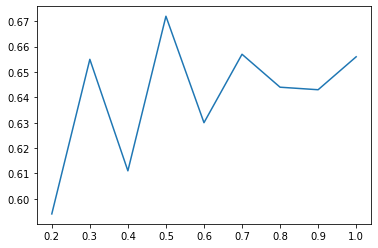

Length of vocab: 9849
Number of epochs = 20, Loss=2.849
Accuracy on dev set=0.674
Length of vocab: 9993


KeyboardInterrupt: 

In [6]:

ps, scores = [], []
for i in range(20, 101, 10):
    p = i/100
    data_size = int(base_len + p*new_len - 1) # exclusive to avoid indexing [-1:]
    X = X_all[-data_size:] # Go from back, so we always get base data
    Y = Y_all[-data_size:]

    model, vocab = train(X, Y, epochs=20, embed_dim=100, lstm_dim=100, min_df=0., max_df=1., batch_size=512)
    scores.append(score(model, vocab, Xt, Yt))
    ps.append(p)
plt.plot(ps, scores)
plt.show()

Length of vocab: 2784
Number of epochs = 20, Loss=1.940
Accuracy on dev set=0.56
Length of vocab: 3178
Number of epochs = 20, Loss=2.531
Accuracy on dev set=0.569
Length of vocab: 3573
Number of epochs = 20, Loss=3.019
Accuracy on dev set=0.609
Length of vocab: 3929
Number of epochs = 20, Loss=3.006
Accuracy on dev set=0.648
Length of vocab: 4239
Number of epochs = 20, Loss=2.839
Accuracy on dev set=0.649
Length of vocab: 4512
Number of epochs = 20, Loss=3.467
Accuracy on dev set=0.666


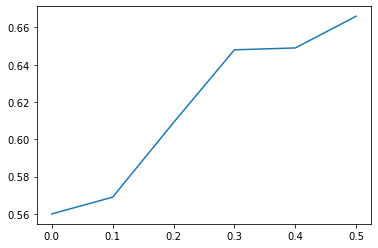

In [4]:
for min_df in [0]:
    ps, scores = [], []
    for i in range(0, 51, 10):
        p = i/100
        data_size = int(base_len + p*new_len - 1) # exclusive to avoid indexing [-1:]
        X = X_all[-data_size:] # Go from back, so we always get base data
        Y = Y_all[-data_size:]

        model, vocab = train(X, Y, epochs=20, embed_dim=100, lstm_dim=100, min_df=3, batch_size=512)
        scores.append(score(model, vocab, Xt, Yt))
        ps.append(p)
    plt.plot(ps, scores)
    plt.show()

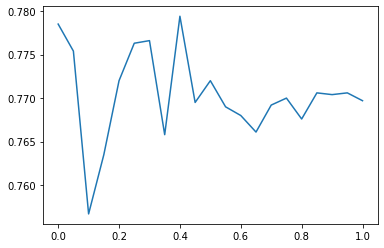

In [8]:
class OnehotTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def convert(self, sentence):# [[w1, w2, w3], [w1, w2, w3]]
        output = [0]*len(self.vocab)
        for word in sentence.split():
            word = word.lower()
            if word in self.vocab:
                output[self.vocab[word]] = 1
        return output

    def fit(self, X, y=None):
        vectorizer = TfidfVectorizer(min_df = 25)
        vectorizer.fit(X)
        self.vocab = vectorizer.vocabulary_
        return self
    
    def transform(self, X, y=None):
        X_ = [self.convert(row) for row in X]
        return X_

ps, scores = [], []
for i in range(0, 101, 5):
    p = i/100
    data_size = int(base_len + p*new_len - 1) # exclusive to avoid indexing [-1:]
    X = X_all[-data_size:] # Go from back, so we always get base data
    Y = Y_all[-data_size:]

    pipe = Pipeline([
        ('onehot', OnehotTransformer()),
        ('clf', LogisticRegression(max_iter=1000))
    ])
    pipe.fit(X, Y)
    
    scores.append(pipe.score(Xt, Yt))
    ps.append(p)
plt.plot(ps, scores)